Import all the needed function at once

In [23]:
import sys
sys.path.append('./util_function/')  # Make sure this path is correct relative to your current working directory.

from function_data_preprocessing import *
from function_model import *
from function_evaluate import *
from util_function.function_model import CNN_Model,Bilstm_Model,CNN_Bilstm_sequential_Model,CNN_Bilstm_parallel_Model
from util_function.function_evaluate import evaluate_and_save_results
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from IPython.display import Image




In [24]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

First step: Preprocessing the data


In [25]:
# Load the dataset
file_path = 'NASA_Battery_dataset/B0005.csv'
data = pd.read_csv(file_path)

In [26]:
# Selecting the target and feature columns for model training
target_column = 'capacity'
# choose 3 linear realtionship features with capacity
feature_columns_autoencoder = data.columns.drop(target_column)
# Extracting the feature and target data
target_data = data[target_column].values
Autoencoder_data = data[feature_columns_autoencoder].values
# Defining the window size for the model
window_size = 5  # Number of time steps used for prediction
smooth_y = np.load('./datasaved/smoothed_B0005_capacity.npy')
smooth_y_origin = smooth_y
# Creating input-output pairs for model training
X_autoencoder, y = create_windows(Autoencoder_data, target_data, window_size)
X_autoencoder, smooth_y = create_windows(Autoencoder_data , smooth_y_origin, window_size)


#Preprocessing the data
X_autoencoder_train, X_autoencoder_test, y_train, y_test = train_test_split(X_autoencoder, y, test_size=0.2, shuffle=False)
X_autoencoder_train, X_autoencoder_test, smooth_y_train, smooth_y_test = train_test_split(X_autoencoder, smooth_y, test_size=0.2, shuffle=False)
# Standard Scaling the data
scaler_autoencoder = StandardScaler()
X_autoencoder_train_scaled = scaler_autoencoder.fit_transform(X_autoencoder_train.reshape(-1, X_autoencoder_train.shape[-1])).reshape(X_autoencoder_train.shape)
X_autoencoder_test_scaled = scaler_autoencoder.transform(X_autoencoder_test.reshape(-1, X_autoencoder_test.shape[-1])).reshape(X_autoencoder_test.shape)

In [27]:
print("X_autoencoder_train shape:", X_autoencoder_train.shape)
print("X_autoencoder_test shape:", X_autoencoder_test.shape)

X_autoencoder_train shape: (129, 5, 21)
X_autoencoder_test shape: (33, 5, 21)


In [28]:
#Autoencoder model
input_dim = X_autoencoder_train_scaled.shape[-1]  # Assuming 20 features per time step
timesteps = window_size  # Assuming 5 time steps per sequence
# Create the model
autoencoder = Autoencoder_Model(input_dim, timesteps)
# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = autoencoder.fit(
    X_autoencoder_train_scaled,  X_autoencoder_train_scaled,
    epochs=5000,
    batch_size=32,
    validation_data=(X_autoencoder_test_scaled,X_autoencoder_test_scaled),
    callbacks=[early_stopping],
    verbose=1
)
# Evaluate the model on the test data using the best epoch's model
loss, metric = autoencoder.evaluate(X_autoencoder_test_scaled, X_autoencoder_test_scaled, verbose=0)  # 'metric' should be replaced with the actual metric name you're using

# Find the best epoch and validation loss
best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
val_loss = min(history.history['val_loss'])
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {val_loss}")

# Save the model
autoencoder.save('./pretrained_model/Autoencoder.h5')



Epoch 1/5000
5/5 [==============================] - 3s 140ms/step - loss: 1.0095 - rmse_percentage: inf - val_loss: 1.3343 - val_rmse_percentage: 129.1952
Epoch 2/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.9877 - rmse_percentage: inf - val_loss: 1.3019 - val_rmse_percentage: 120.6953
Epoch 3/5000
5/5 [==============================] - 0s 9ms/step - loss: 0.9670 - rmse_percentage: inf - val_loss: 1.2731 - val_rmse_percentage: 116.4281
Epoch 4/5000
5/5 [==============================] - 0s 9ms/step - loss: 0.9481 - rmse_percentage: inf - val_loss: 1.2466 - val_rmse_percentage: 115.0023
Epoch 5/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.9310 - rmse_percentage: inf - val_loss: 1.2201 - val_rmse_percentage: 115.8710
Epoch 6/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.9126 - rmse_percentage: inf - val_loss: 1.1950 - val_rmse_percentage: 118.1146
Epoch 7/5000
5/5 [==============================] - 0s 8ms/step - loss: 0.8916 -

In [29]:
custom_objects = {'rmse': rmse, 'rmse_percentage': rmse_percentage}
loaded_model = load_model('./pretrained_model/Autoencoder.h5',custom_objects=custom_objects)
autoencoder = loaded_model
Autoencoder_predictions = autoencoder.predict(X_autoencoder_test_scaled)
Autoencoder_predictions_train = autoencoder.predict(X_autoencoder_train_scaled)
np.save('./datasaved/Autoencoder_predictions.npy', Autoencoder_predictions)
np.save('./datasaved/Autoencoder_predictions_train.npy', Autoencoder_predictions_train)

5/5 [==============================] - 0s 2ms/step


In [30]:
#Evaluate the model and save the results
Autoencoder_predictions = np.load('./datasaved/Autoencoder_predictions.npy')
absolute_errors = np.abs(X_autoencoder_test_scaled - Autoencoder_predictions)
np.save('./datasaved/absolute_errors_B0005_Autoencoder.npy', absolute_errors)
print('\nThis is the evaluation results of Autoencoder\n')
evaluation_results = evaluate_and_save_results(X_autoencoder_test_scaled, Autoencoder_predictions,file_path='./evaluate_result/B0005_Autoencoder.txt')


This is the evaluation results of Autoencoder

MAE: 0.5216703754363734
RMSE: 0.6817484173837566
RMSE Percentage: 250.68397502923622


In [31]:
# Save the encoder model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-2].output)
encoder.save('./pretrained_model/encoder.h5')
# Encode the training and test data
X_encoded_train = encoder.predict(X_autoencoder_train_scaled)
X_encoded_test = encoder.predict(X_autoencoder_test_scaled)
np.save('./datasaved/X_encoded_train.npy', X_encoded_train)
np.save('./datasaved/X_encoded_test.npy', X_encoded_test)

2/2 [==============================] - 0s 2ms/step


In [32]:
# Create the CNN model
model = CNN_Model(input_shape=(X_encoded_train.shape[1], X_encoded_train.shape[2]))

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    X_encoded_train, smooth_y_train,
    epochs=3000,
    batch_size=32,
    validation_data=(X_encoded_test, smooth_y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test data using the best epoch's model
loss, metric = model.evaluate(X_encoded_test, smooth_y_test, verbose=0)  # 'metric' should be replaced with the actual metric name you're using

# Find the best epoch and validation loss
best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
val_loss = min(history.history['val_loss'])
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {val_loss}")

# Save the model
model.save('./pretrained_model/cnn_model.h5')

Epoch 1/3000
5/5 [==============================] - 1s 60ms/step - loss: 1.3133 - rmse_percentage: 66.1605 - val_loss: 0.3543 - val_rmse_percentage: 25.6467
Epoch 2/3000
5/5 [==============================] - 0s 8ms/step - loss: 0.3307 - rmse_percentage: 25.5747 - val_loss: 0.4650 - val_rmse_percentage: 35.9975
Epoch 3/3000
5/5 [==============================] - 0s 9ms/step - loss: 0.2252 - rmse_percentage: 13.4910 - val_loss: 0.2754 - val_rmse_percentage: 17.0219
Epoch 4/3000
5/5 [==============================] - 0s 7ms/step - loss: 0.2488 - rmse_percentage: 15.2525 - val_loss: 0.1453 - val_rmse_percentage: 5.9511
Epoch 5/3000
5/5 [==============================] - 0s 8ms/step - loss: 0.2006 - rmse_percentage: 10.5297 - val_loss: 0.2738 - val_rmse_percentage: 21.3204
Epoch 6/3000
5/5 [==============================] - 0s 9ms/step - loss: 0.1828 - rmse_percentage: 10.9214 - val_loss: 0.4680 - val_rmse_percentage: 36.6979
Epoch 7/3000
5/5 [==============================] - 0s 11ms/step

In [33]:
custom_objects = {'rmse': rmse, 'rmse_percentage': rmse_percentage}
loaded_model = load_model('./pretrained_model/cnn_model.h5',custom_objects=custom_objects)
model = loaded_model
# Make predictions
CNN_predictions = model.predict(X_encoded_test).flatten()
CNN_predictions_train = model.predict(X_encoded_train).flatten()
np.save('./datasaved/CNN_predictions.npy', CNN_predictions)
np.save('./datasaved/CNN_predictions_train.npy', CNN_predictions_train)

5/5 [==============================] - 0s 2ms/step


In [34]:
# Evaluate the model and save the results
CNN_predictions = np.load('./datasaved/CNN_predictions.npy')
absolute_errors = np.abs(y_test - CNN_predictions)
np.save('./datasaved/absolute_errors_B0005_CNN.npy', absolute_errors)
print('\nThis is the evaluation results using Non-smooth data\n')
evaluation_results = evaluate_and_save_results(y_test, CNN_predictions,file_path='./evaluate_result/B0005_CNN_Non_smooth_compare.txt')
print('\nThis is the evaluation results using smooth data\n')
evaluation_results = evaluate_and_save_results(smooth_y_test, CNN_predictions,file_path='./evaluate_result/B0005_CNN_smooth_compare.txt')



This is the evaluation results using Non-smooth data

MAE: 0.026935572814341023
RMSE: 0.03266104193910634
RMSE Percentage: 2.4659309022602787

This is the evaluation results using smooth data

MAE: 0.02147913859002377
RMSE: 0.03056929035790139
RMSE Percentage: 2.357668147645897


In [35]:
# Create the BiLSTM model
model = Bilstm_Model(input_shape=(X_encoded_train.shape[1], X_encoded_train.shape[2]))

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    X_encoded_train, smooth_y_train,
    epochs=3000,
    batch_size=32,
    validation_data=(X_encoded_test, smooth_y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test data using the best epoch's model
loss, metric = model.evaluate(X_encoded_test, smooth_y_test, verbose=0)  # 'metric' should be replaced with the actual metric name you're using

# Find the best epoch and validation loss
best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
val_loss = min(history.history['val_loss'])
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {val_loss}")

# Save the model
model.save('./pretrained_model/Bilstm_model.h5')

Epoch 1/3000
5/5 [==============================] - 9s 393ms/step - loss: 1.6410 - rmse_percentage: 98.8620 - val_loss: 1.1605 - val_rmse_percentage: 86.0344
Epoch 2/3000
5/5 [==============================] - 0s 14ms/step - loss: 1.4339 - rmse_percentage: 86.2931 - val_loss: 1.0455 - val_rmse_percentage: 77.6241
Epoch 3/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.2364 - rmse_percentage: 73.4222 - val_loss: 0.9147 - val_rmse_percentage: 67.9227
Epoch 4/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.0248 - rmse_percentage: 58.3459 - val_loss: 0.7466 - val_rmse_percentage: 55.2783
Epoch 5/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.7851 - rmse_percentage: 42.5525 - val_loss: 0.5141 - val_rmse_percentage: 37.5786
Epoch 6/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.5134 - rmse_percentage: 28.7243 - val_loss: 0.2284 - val_rmse_percentage: 15.5780
Epoch 7/3000
5/5 [==============================] - 0s 11

In [36]:
custom_objects = {'rmse': rmse, 'rmse_percentage': rmse_percentage}
loaded_model = load_model('./pretrained_model/Bilstm_model.h5',custom_objects=custom_objects)
model = loaded_model
# Make predictions
Bilstm_predictions = model.predict(X_encoded_test).flatten()
Bilstm_predictions_train = model.predict(X_encoded_train).flatten()
np.save('./datasaved/Bilstm_predictions.npy', Bilstm_predictions)
np.save('./datasaved/Bilstm_predictions_train.npy', Bilstm_predictions_train)

5/5 [==============================] - 0s 771us/step


In [37]:
# Evaluate the model and save the results
BiLstm_predictions = np.load('./datasaved/Bilstm_predictions.npy')
absolute_errors = np.abs(y_test - BiLstm_predictions)
np.save('./datasaved/absolute_errors_B0005_Bilstm.npy', absolute_errors)
print('\nThis is the evaluation results using Non-smooth data\n')
evaluation_results = evaluate_and_save_results(y_test, BiLstm_predictions,file_path='./evaluate_result/B0005_BiLstm_Non_smooth_compare.txt')
print('\nThis is the evaluation results using smooth data\n')
evaluation_results = evaluate_and_save_results(smooth_y_test, BiLstm_predictions,file_path='./evaluate_result/B0005_BiLstm_smooth_compare.txt')



This is the evaluation results using Non-smooth data

MAE: 0.011012422837275626
RMSE: 0.014144146645904345
RMSE Percentage: 1.0614550996147099

This is the evaluation results using smooth data

MAE: 0.018528649777851982
RMSE: 0.022473521508887897
RMSE Percentage: 1.7215712313293168


In [38]:
# Create the CNN_BiLSTM-S model
model = CNN_Bilstm_sequential_Model(input_shape=(X_encoded_train.shape[1], X_encoded_train.shape[2]))

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    X_encoded_train, smooth_y_train,
    epochs=3000,
    batch_size=32,
    validation_data=(X_encoded_test, smooth_y_test),
    callbacks=[early_stopping],
    verbose=1
)
# Evaluate the model on the test data using the best epoch's model
loss, metric = model.evaluate(X_encoded_test, smooth_y_test, verbose=0)  # 'metric' should be replaced with the actual metric name you're using

# Find the best epoch and validation loss
best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
val_loss = min(history.history['val_loss'])
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {val_loss}")

# Save the model
model.save('./pretrained_model/CNN_Bilstm_sequential_Model.h5')

Epoch 1/3000
5/5 [==============================] - 8s 200ms/step - loss: 1.4907 - rmse_percentage: 91.9421 - val_loss: 1.0489 - val_rmse_percentage: 78.0556
Epoch 2/3000
5/5 [==============================] - 0s 8ms/step - loss: 1.2693 - rmse_percentage: 69.5927 - val_loss: 0.7885 - val_rmse_percentage: 57.8023
Epoch 3/3000
5/5 [==============================] - 0s 8ms/step - loss: 1.0981 - rmse_percentage: 56.9255 - val_loss: 0.4539 - val_rmse_percentage: 31.9033
Epoch 4/3000
5/5 [==============================] - 0s 9ms/step - loss: 0.7541 - rmse_percentage: 41.2172 - val_loss: 0.0571 - val_rmse_percentage: 2.9822
Epoch 5/3000
5/5 [==============================] - 0s 8ms/step - loss: 0.6468 - rmse_percentage: 40.4974 - val_loss: 0.3202 - val_rmse_percentage: 26.1016
Epoch 6/3000
5/5 [==============================] - 0s 8ms/step - loss: 0.7306 - rmse_percentage: 36.8380 - val_loss: 0.4290 - val_rmse_percentage: 34.5046
Epoch 7/3000
5/5 [==============================] - 0s 9ms/step

In [39]:
custom_objects = {'rmse': rmse, 'rmse_percentage': rmse_percentage}
loaded_model = load_model('./pretrained_model/CNN_Bilstm_sequential_Model.h5',custom_objects=custom_objects)
model = loaded_model
# Make predictions
CNN_Bilstm_sequential_predictions = model.predict(X_encoded_test).flatten()
CNN_Bilstm_sequential_predictions_train = model.predict(X_encoded_train).flatten()
np.save('./datasaved/CNN_Bilstm_sequential_predictions.npy', CNN_Bilstm_sequential_predictions)
np.save('./datasaved/CNN_Bilstm_sequential_predictions_train.npy', CNN_Bilstm_sequential_predictions_train)

5/5 [==============================] - 0s 2ms/step


In [40]:
# Evaluate the model and save the results
CNN_Bilstm_sequential_predictions = np.load('./datasaved/CNN_Bilstm_sequential_predictions.npy')
absolute_errors = np.abs(y_test - CNN_Bilstm_sequential_predictions)
np.save('./datasaved/absolute_errors_B0005_CNN_Bilstm_sequential.npy', absolute_errors)
print('\nThis is the evaluation results using Non-smooth data\n')
evaluation_results = evaluate_and_save_results(y_test, CNN_Bilstm_sequential_predictions,file_path='./evaluate_result/B0005_CNN_BiLstm_sequential_Non_smooth_compare.txt')
print('\nThis is the evaluation results using smooth data\n')
evaluation_results = evaluate_and_save_results(smooth_y_test, CNN_Bilstm_sequential_predictions,file_path='./evaluate_result/B0005_CNN_BiLstm_sequential_smooth_compare.txt')


This is the evaluation results using Non-smooth data

MAE: 0.017737057231167776
RMSE: 0.021153850719568226
RMSE Percentage: 1.6126511643289498

This is the evaluation results using smooth data

MAE: 0.02205287532636634
RMSE: 0.030950755485601514
RMSE Percentage: 2.4150541261001135


In [41]:
# Create the CNN-BiLSTM-P model
model = CNN_Bilstm_parallel_Model(input_shape=(X_encoded_train.shape[1], X_encoded_train.shape[2]))

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    [X_encoded_train,X_encoded_train], smooth_y_train,
    epochs=3000,
    batch_size=32,
    validation_data=([X_encoded_test,X_encoded_test], smooth_y_test),
    callbacks=[early_stopping],
    verbose=1
)
# Evaluate the model on the test data using the best epoch's model
loss, metric = model.evaluate([X_encoded_test,X_encoded_test], smooth_y_test, verbose=0)  # 'metric' should be replaced with the actual metric name you're using

# Find the best epoch and validation loss
best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
val_loss = min(history.history['val_loss'])
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {val_loss}")

# Save the model
model.save('./pretrained_model/CNN_Bilstm_parallel_Model.h5')

Epoch 1/3000
5/5 [==============================] - 9s 210ms/step - loss: 1.4621 - rmse_percentage: 84.9277 - val_loss: 0.3655 - val_rmse_percentage: 22.7024
Epoch 2/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.6740 - rmse_percentage: 35.6197 - val_loss: 0.5322 - val_rmse_percentage: 41.9593
Epoch 3/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.5426 - rmse_percentage: 34.4773 - val_loss: 0.2070 - val_rmse_percentage: 16.2044
Epoch 4/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.4498 - rmse_percentage: 22.5547 - val_loss: 0.2206 - val_rmse_percentage: 11.2259
Epoch 5/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.3849 - rmse_percentage: 18.5193 - val_loss: 0.2832 - val_rmse_percentage: 16.6528
Epoch 6/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.3738 - rmse_percentage: 16.8986 - val_loss: 0.3226 - val_rmse_percentage: 20.0804
Epoch 7/3000
5/5 [==============================] - 0s 12

In [42]:
custom_objects = {'rmse': rmse, 'rmse_percentage': rmse_percentage}
loaded_model = load_model('./pretrained_model/CNN_Bilstm_parallel_Model.h5',custom_objects=custom_objects)
model = loaded_model
# Make predictions
CNN_Bilstm_parallel_predictions = model.predict([X_encoded_test,X_encoded_test]).flatten()
CNN_Bilstm_parallel_predictions_train = model.predict([X_encoded_train,X_encoded_train]).flatten()
np.save('./datasaved/CNN_Bilstm_parallel_predictions.npy', CNN_Bilstm_parallel_predictions)
np.save('./datasaved/CNN_Bilstm_parallel_predictions_train.npy', CNN_Bilstm_parallel_predictions_train)

5/5 [==============================] - 0s 2ms/step


In [43]:
# Evaluate the model and save the results
CNN_Bilstm_parallel_predictions = np.load('./datasaved/CNN_Bilstm_parallel_predictions.npy')
absolute_errors = np.abs(y_test - CNN_Bilstm_parallel_predictions)
np.save('./datasaved/absolute_errors_B0005_CNN_Bilstm_parallel.npy', absolute_errors)
print('\nThis is the evaluation results using Non-smooth data\n')
evaluation_results = evaluate_and_save_results(y_test, CNN_Bilstm_parallel_predictions,file_path='./evaluate_result/B0005_CNN_BiLstm_parallel_Non_smooth_compare.txt')
print('\nThis is the evaluation results using smooth data\n')
evaluation_results = evaluate_and_save_results(smooth_y_test, CNN_Bilstm_parallel_predictions,file_path='./evaluate_result/B0005_CNN_BiLstm_parallel_smooth_compare.txt')


This is the evaluation results using Non-smooth data

MAE: 0.019681920686413463
RMSE: 0.022851435921437086
RMSE Percentage: 1.7378412193837793

This is the evaluation results using smooth data

MAE: 0.02543649717764809
RMSE: 0.03164489947886027
RMSE Percentage: 2.4574083035341765


This is the model architecture of Autoencoder:


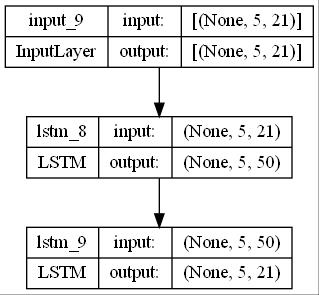

This is the model architecture of CNN:


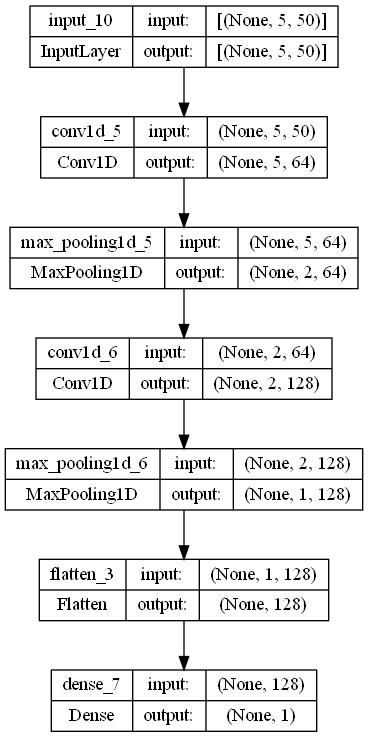

This is the model architecture of BiLSTM:


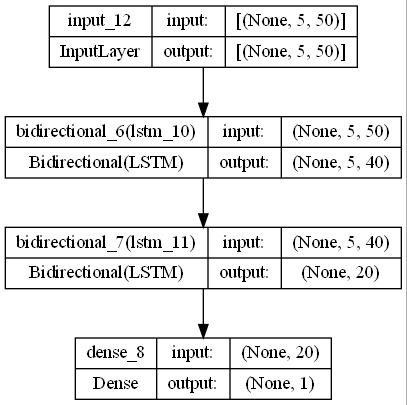

This is the model architecture of CNN-BiLSTM Sequential:


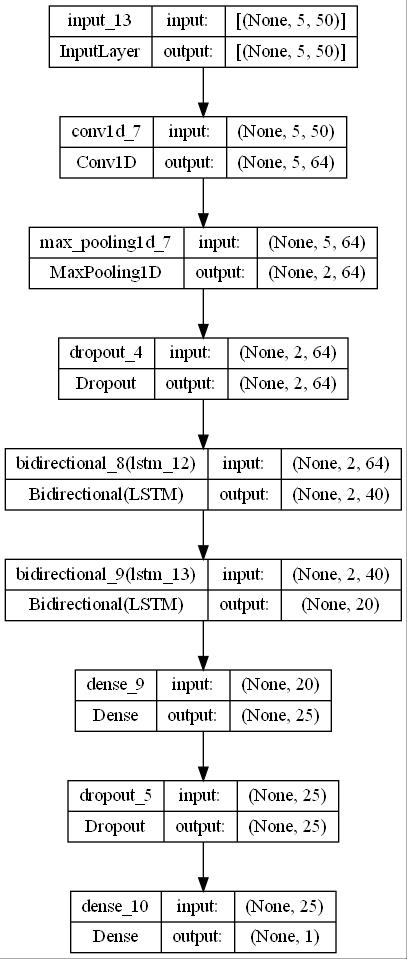

This is the model architecture of CNN-BiLSTM Parallel:


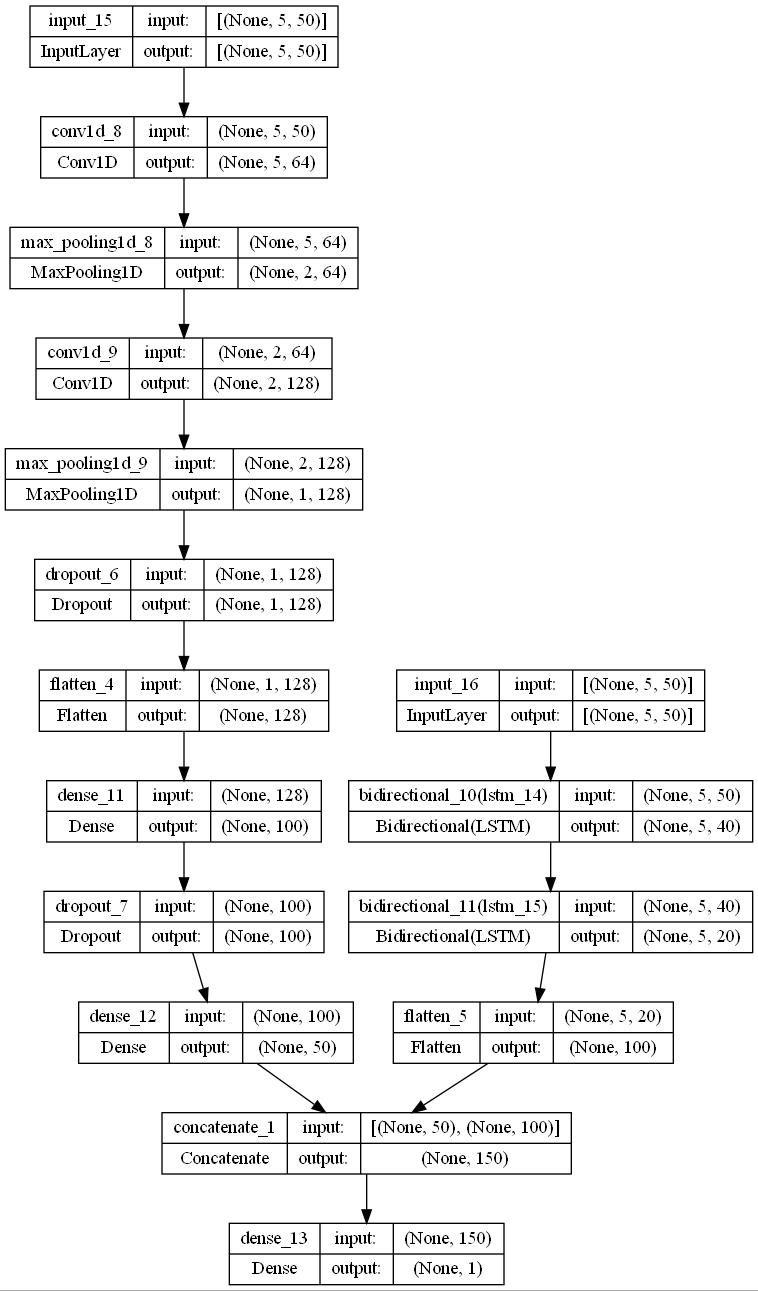

In [44]:
# Load the models and plot the architecture
from IPython.display import display, Image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Define custom objects for loading models
custom_objects = {'rmse': rmse, 'rmse_percentage': rmse_percentage}

# Load and plot each model architecture
models = {
    'Autoencoder': './pretrained_model/Autoencoder.h5',
    'CNN': './pretrained_model/cnn_model.h5',
    'BiLSTM': './pretrained_model/Bilstm_model.h5',
    'CNN-BiLSTM Sequential': './pretrained_model/CNN_Bilstm_sequential_Model.h5',
    'CNN-BiLSTM Parallel': './pretrained_model/CNN_Bilstm_parallel_Model.h5'
}


# Path for saving images
image_path = './graph_model_architecture/'
 
# Loop through the models, plot, save, and display each architecture
for name, model_path in models.items():
    # Load model
    model = load_model(model_path, custom_objects=custom_objects)
    
    # Plot and save model architecture
    plot_model(model, to_file=f'{image_path}{name}.jpg', show_shapes=True, show_layer_names=True)
    
    # Print the name of the model architecture
    print(f"This is the model architecture of {name}:")
    
    # Display the saved image
    display(Image(f'{image_path}{name}.jpg'))

